# ALOS-2から浸水確率ラスターデータの生成

GPUを設定してください。
「ランタイム」⇒「ランタイムのタイプを変更」より行えます。<br>
詳しくは https://research.google.com/colaboratory/faq.html#gpu-utilization

広域の場合、実行には数分かかります。

In [ ]:
# @title Googleドライブの準備
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

# @title パラメータの設定
casename = "omuta-r2"

date = "2020-07-08"


In [ ]:
tif_name = "IMG-HH-AS201373106515-200708___-SM_R1.5RUA_.tif" # @param

In [ ]:
# @title 詳細設定用パラメータ（基本的には操作不要）

polmode = "hh"
enable_savefig = False # 図をGoogleドライブに保存する？

# 機械学習用パラメータ
# median = -17.233137786388397
# std_dev = 5.842539646934703

## マスク＆データ拡張版
median = -14.373820960521698
std_dev = 6.312272332690032

# デバッグ用出力
global globalflag_debug

# 保存先
path_home = "/content/drive/MyDrive/plateau-2023-uc01-satellite-analytics/PLATEAU-FloodSAR/"
path_case = path_home + casename + "/"
path_model = path_home+"models/"
file_boundary = path_case+"boundary.json"
file_bbox = path_case + "boundbox.npy"
file_prb = path_case + "floodprb.pt"
file_fldbbox = path_case + "floodprb_bbox.npy"
file_pts = path_case + "flood_points.pkl"

tif_path = path_case + tif_name

## 各種読み込み

In [ ]:
!pip install rasterio pyproj
!pip install geojson

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 49.3 MB/s eta 0:00:00


In [ ]:
# @title 主要ライブラリインポート
import math
import numpy as np
import scipy
from scipy.ndimage import gaussian_filter
from scipy.interpolate import RectBivariateSpline

import pyproj
from pyproj import CRS
from pyproj import Transformer

import rasterio
from rasterio.plot import show


from datetime import datetime, timedelta

import os
import zipfile
import requests
import matplotlib.pyplot as plt

import pickle
from progressbar import progressbar

In [ ]:
# @title 基本的な関数

# WGS84 (EPSG:4326) to JGD2011(EPSG:6668)
transformer_wgs84_jgd2011 = pyproj.Transformer.from_crs("epsg:4326", "epsg:6668", always_xy=True)
convert_wgs84_jgd2011 = transformer_wgs84_jgd2011.transform
#print(convert_wgs84_jgd2011(130.2,35))

def coordinates_to_rect(coordinates):
  #coordinates = coordinates[0]

  lon_min = min(coordinates, key=lambda x: x[0])[0]
  lon_max = max(coordinates, key=lambda x: x[0])[0]
  lat_min = min(coordinates, key=lambda x: x[1])[1]
  lat_max = max(coordinates, key=lambda x: x[1])[1]
  # rasterio bounds tuple (left, bottom, right, top)
  # https://rasterio.readthedocs.io/en/stable/api/rasterio.coords.html
  return (lon_min, lat_min, lon_max, lat_max)

In [ ]:
def meters_to_degrees(meters, lat):
  width = meters / (111319.44 * math.cos(math.radians(lat)))
  height = meters / 111319.44
  return (width, height)

In [ ]:
# @title 設定ファイルの読み込み
boundbox = np.load(file_bbox)

############## old code
#import geojson

#boundary = []
#with open(file_boundary) as ifile:
#  txt = ifile.read()
#  print(txt)
#  tmp = geojson.loads(txt)
#  for vv in tmp:
#    for pp in vv["coordinates"]:
#      boundary.extend(pp)
#print(boundary)
#boundbox = coordinates_to_rect(boundary)

print(boundbox)
center = {
    "lon": (boundbox[0]+boundbox[2])*0.5,
    "lat": (boundbox[1]+boundbox[3])*0.5
}
print(center)

[130.38311   32.991771 130.545845  33.103334]
{'lon': 130.4644775, 'lat': 33.047552499999995}


## SAR画像による水面推定＆浸水深推定（WIP）

In [ ]:
def load_trim_data(tif_path, bounds):
  data = rasterio.open(tif_path)
  #print(data.gcps)
  #gcps, gcp_crs = data.gcps
  #print("GCP_CRS: ", gcp_crs)
  #print(data.transform)
  #print(data.tags())
  #print(data.meta)
  #tags = data.tags()
  #clat = float(tags['CEOS_PLATFORM_LATITUDE'])
  #clon = float(tags['CEOS_PLATFORM_LONGITUDE'])
  clon = (bounds[0] + bounds[2])*0.5
  clat = (bounds[1] + bounds[3])*0.5
  espg = 32600 if clat >= 0 else 32700
  espg += int((clon+180)/6) + 1
  crs = CRS.from_epsg(espg)
  #print(crs)
  trans_coord = Transformer.from_crs(crs, "EPSG:4326", always_xy=True)
  idx_trans_matrix = np.reshape(np.array(data.transform),(3,3))
  idx_transform = lambda idx, idy : np.matmul(idx_trans_matrix, [idx, idy, 1])[:2]
  #print(idx_trans_matrix)
  #print(np.shape(idx_trans_matrix))
  band = data.read(1)
  #print(np.shape(band))
  dd = 100
  iys = np.arange(0,np.shape(band)[0],dd)
  ixs = np.arange(0,np.shape(band)[1],dd)
  idxx, idyy = np.meshgrid(ixs,iys)
  #print(len(iys), len(ixs), np.shape(idxx))

  gcpxx = np.zeros_like(idxx, dtype=float)
  gcpyy = np.zeros_like(idxx, dtype=float)
  for jj in progressbar(np.arange(len(iys))):
    for ii in np.arange(len(ixs)):
      xx, yy = idx_transform(idxx[jj,ii], idyy[jj,ii])
      gcpxx[jj,ii], gcpyy[jj,ii] =  trans_coord.transform(xx,yy)
  gcpInterpX = RectBivariateSpline(iys, ixs, gcpxx)
  gcpInterpY = RectBivariateSpline(iys, ixs, gcpyy)
  xs = np.arange(band.shape[0])
  ys = np.arange(band.shape[1])
  gcplons = gcpInterpX(xs, ys)
  gcplats = gcpInterpY(xs, ys)
  msk = (bounds[0] <= gcplons) * (gcplons <= bounds[2]) * (bounds[1] <= gcplats) * (gcplats <= bounds[3])

  trim_msk_x = np.any(msk, axis=0)
  trim_msk_y = np.any(msk, axis=1)

  band_trim = band[trim_msk_y,:][:,trim_msk_x]
  lons_trim = gcplons[trim_msk_y,:][:,trim_msk_x]
  lats_trim = gcplats[trim_msk_y,:][:,trim_msk_x]

  return lons_trim, lats_trim, band_trim

In [ ]:
lons, lats, data = load_trim_data(tif_path, boundbox)

100% (121 of 121) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


<ipython-input-12-09a2b6ccd007>:4: RuntimeWarning: divide by zero encountered in log10
  im = ax.contourf(lons[::dd,::dd], lats[::dd,::dd], np.log10(data[::dd,::dd])<0.7, showlevels, cmap="gist_earth")


(130.36314376664728,
 130.50902243702782,
 32.992823060359456,
 33.116361482386736)

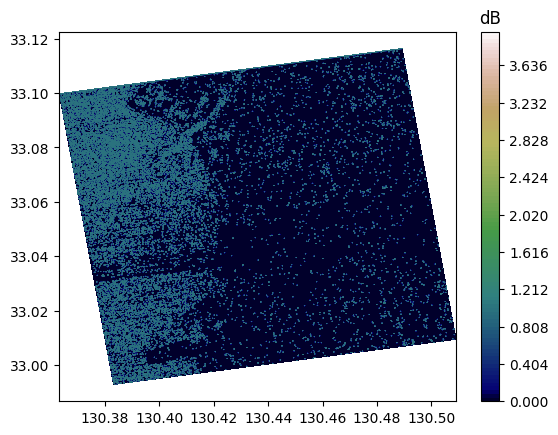

In [ ]:
showlevels = np.linspace(0, 4, 100, endpoint=True)
fig, ax = plt.subplots()
dd = 20
im = ax.contourf(lons[::dd,::dd], lats[::dd,::dd], np.log10(data[::dd,::dd])<0.7, showlevels, cmap="gist_earth")
cbar = fig.colorbar(im)
cbar.ax.set_title('dB')
ax.axis('equal')

In [ ]:
wtr = np.log10(data) < 0.7

<ipython-input-13-6658c626814f>:1: RuntimeWarning: divide by zero encountered in log10
  wtr = np.log10(data) < 0.7


In [ ]:
print(np.shape(wtr[0::10,0::10]))

(1210, 1201)


In [ ]:
dd = 5
tmp = np.copy(wtr[::dd,:-8]+0)
for ii in np.arange(1,dd):
  tmp += wtr[ii::dd,:-8]
#print(np.shape(tmp))
wtr_red = np.copy(tmp[:,::dd]+0)
#print(np.shape(wtr_red))
for ii in np.arange(1,dd):
  wtr_red += tmp[:,ii::dd]
del tmp
lons_red = lons[::dd,:-8:dd]
lats_red = lats[::dd,:-8:dd]

In [ ]:
print(np.sum(wtr_red>10))

175615


(130.36314376664728,
 130.50902243702782,
 32.992823060359456,
 33.116361482386736)

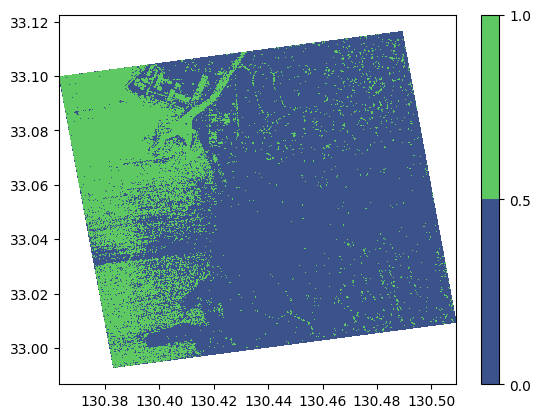

In [ ]:
fig, ax = plt.subplots()
im = ax.contourf(lons_red, lats_red, wtr_red> 0.5*(dd**2))
cbar = fig.colorbar(im)
ax.axis('equal')

In [ ]:
bbox = [np.min(lons_red),np.min(lats_red),np.max(lons_red),np.max(lats_red)]
np.save(file_fldbbox, bbox)

In [ ]:
num_pt_px = 1
flood_pts = []
ny, nx = wtr_red.shape
for jj in progressbar(range(ny)):
  for ii in range(nx):
    if wtr_red[jj,ii] > 0.5*(dd**2):
      for pp in range(num_pt_px):
        lon_sub = lons_red[jj:jj+2,ii:ii+2]
        lat_sub = lats_red[jj:jj+2,ii:ii+2]
        rx = np.random.rand()
        ry = np.random.rand()
        weight = np.array([[(1-ry)*(1-rx), (1-ry)*rx],[ry*(1-rx), ry*rx]])
        lon = np.sum(lon_sub*weight)
        lat = np.sum(lat_sub*weight)
        #print((idx_x, idx_y), " : ", (lon, lat))
        flood_pts.append({"lon":lon, "lat":lat})
print(len(flood_pts))
print(flood_pts[0:3])

100% (2420 of 2420) |####################| Elapsed Time: 0:00:21 Time:  0:00:21


114179
[{'lon': 130.36384773275884, 'lat': 33.099819948941324}, {'lon': 130.36406022635168, 'lat': 33.099832253711504}, {'lon': 130.36423720115403, 'lat': 33.09984534602453}]


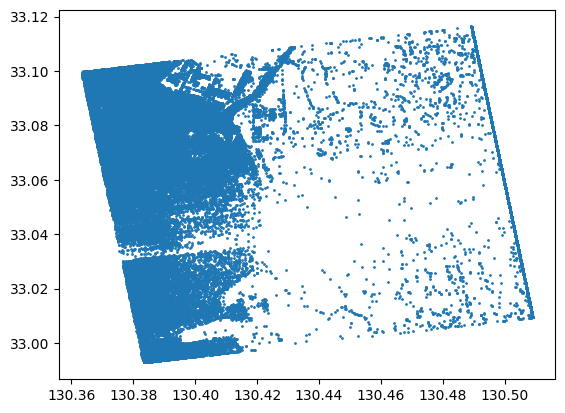

In [ ]:
plt_lons = [pt["lon"] for pt in flood_pts]
plt_lats = [pt["lat"] for pt in flood_pts]
plt.scatter(plt_lons, plt_lats,s=1)

In [ ]:
print(file_pts)
with open(file_pts, "wb") as ofile:
  pickle.dump(flood_pts, ofile)

/content/drive/MyDrive/plateau-2023-uc01-satellite-analytics/PLATEAU-FloodSAR/omuta-r2/flood_points.pkl
